<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectifs-:" data-toc-modified-id="Objectifs-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectifs :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span><ul class="toc-item"><li><span><a href="#Lecture-et-pre-processing" data-toc-modified-id="Lecture-et-pre-processing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lecture et pre-processing</a></span></li><li><span><a href="#Feature-engi" data-toc-modified-id="Feature-engi-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Feature engi</a></span></li><li><span><a href="#Clustering-by-station" data-toc-modified-id="Clustering-by-station-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering by station</a></span><ul class="toc-item"><li><span><a href="#On-compare-par-rapport-au-données-post-covid" data-toc-modified-id="On-compare-par-rapport-au-données-post-covid-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>On compare par rapport au données post-covid</a></span></li></ul></li></ul></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Analyse-du-score-d'anomalie-pour-un-trimestre-différent" data-toc-modified-id="Analyse-du-score-d'anomalie-pour-un-trimestre-différent-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analyse du score d'anomalie pour un trimestre différent</a></span></li></ul></li></ul></div>

In [1]:
from datetime import datetime

import pandas as pd
import plotly.express as px
import polars as pl
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from vcub_keeper.config import (
    FEATURES_TO_USE_CLUSTER,
    NON_USE_STATION_ID,
    PROFILE_STATION_RULE,
    ROOT_DATA_CLEAN,
    ROOT_DATA_REF,
    SEED,
    THRESHOLD_PROFILE_STATION,
)
from vcub_keeper.ml.cluster import logistic_predict_proba_from_model, predict_anomalies_station, train_cluster_station
from vcub_keeper.reader.reader import read_station_profile, read_time_serie_activity
from vcub_keeper.reader.reader_utils import filter_periode
from vcub_keeper.transform.features_factory import (
    get_consecutive_no_transactions_out,
    process_data_cluster,
)
from vcub_keeper.visualisation import plot_profile_station

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Objectifs :

- Clusteriser les stations en anomalie
- ML non supervisé
- Exploration des résultats et amélioration
- [Issue Github](https://github.com/armgilles/vcub_keeper/issues/23)

## Dev

### Lecture et pre-processing

In [2]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
# ts_activity = get_transactions_in(ts_activity)
# ts_activity = get_transactions_out(ts_activity)
# ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)

# meteo
# meteo = read_meteo(path_directory=ROOT_DATA_REF)
# ts_activity = get_meteo(data=ts_activity, meteo=meteo)

ts_activity = ts_activity.collect()

In [ ]:
#
ts_activity.shape

(12794673, 9)

In [4]:
ts_activity.select("date").min()

shape: (1, 1)
┌─────────────────────┐
│ date                │
│ ---                 │
│ datetime[ns]        │
╞═════════════════════╡
│ 2018-12-01 00:10:00 │
└─────────────────────┘

In [ ]:
ts_activity.select("date").max()

shape: (1, 1)
┌─────────────────────┐
│ date                │
│ ---                 │
│ datetime[ns]        │
╞═════════════════════╡
│ 2020-08-28 11:50:00 │
└─────────────────────┘

In [ ]:
ts_activity["station_id"].n_unique()

187

In [8]:
ts_activity.tail()

shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ station_i ┆ date      ┆ available ┆ available ┆ … ┆ transacti ┆ transacti ┆ transacti ┆ consecut │
│ d         ┆ ---       ┆ _stands   ┆ _bikes    ┆   ┆ ons_in    ┆ ons_out   ┆ ons_all   ┆ ive_no_t │
│ ---       ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ransacti │
│ u8        ┆ ns]       ┆ i8        ┆ i8        ┆   ┆ i64       ┆ i64       ┆ i64       ┆ ons_ou…  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 5        │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 11:10:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 6        │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 11:20:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ 2         ┆ 0         ┆ 2         ┆ 7        │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 11:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 8        │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 11:40:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 9        │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 11:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Feature engi

In [9]:
ts_activity.shape

(12794673, 9)

In [10]:
# Feature engi for cluster
ts_activity = process_data_cluster(ts_activity)

# Filter data based on time & event
ts_activity = filter_periode(ts_activity, non_use_station_id=NON_USE_STATION_ID)

In [11]:
ts_activity.shape

(11317590, 18)

In [12]:
# Check Covid
# assert len(ts_activity[ts_activity['date'] == "2020-04-18"]) == 0
assert ts_activity.filter(pl.col("date") == datetime(2020, 4, 18)).shape[0] == 0  # noqa: S101

In [13]:
ts_activity.columns

['station_id',
 'date',
 'available_stands',
 'available_bikes',
 'status',
 'transactions_in',
 'transactions_out',
 'transactions_all',
 'consecutive_no_transactions_out',
 'quarter',
 'weekday',
 'hours',
 'Sin_quarter',
 'Cos_quarter',
 'Sin_weekday',
 'Cos_weekday',
 'Sin_hours',
 'Cos_hours']

In [14]:
ts_activity.tail(7)

shape: (7, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ station_i ┆ date      ┆ available ┆ available ┆ … ┆ Sin_weekd ┆ Cos_weekd ┆ Sin_hours ┆ Cos_hour │
│ d         ┆ ---       ┆ _stands   ┆ _bikes    ┆   ┆ ay        ┆ ay        ┆ ---       ┆ s        │
│ ---       ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---      │
│ u8        ┆ ns]       ┆ i8        ┆ i8        ┆   ┆ f64       ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.5       ┆ -0.86602 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│           ┆ 10:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:00:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:10:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 28        ┆ 12        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:20:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:40:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 251       ┆ 2020-08-2 ┆ 26        ┆ 14        ┆ … ┆ -0.974928 ┆ -0.222521 ┆ 0.258819  ┆ -0.96592 │
│           ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│           ┆ 11:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [15]:
def clustering(
    data, clf_cluster, clf_scaler, features_to_use_cluster, pca_n_components=0.9, type_of_clustering="label"
):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA

    Durant la phase de scale / learning la station doit etre en status ==1

    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """

    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data["status"] == 1].copy()

    # Learning
    pipe = Pipeline([("scale", clf_scaler), ("pca", PCA(n_components=0.9)), ("cluster", clf_cluster)])
    pipe.fit(data_status_ok[features_to_use_cluster])

    # Create pca_ features
    for i in range(0, pipe.named_steps["pca"].n_components_):
        data["pca_" + str(i + 1)] = pipe.named_steps["pca"].transform(data[features_to_use_cluster])[:, i]

    # Cluster
    if type_of_clustering == "label":
        data["cluster"] = clustering.labels_
    elif type_of_clustering == "predict":
        data["cluster"] = pipe.predict(data[features_to_use_cluster])
    return data


def clustering_old(
    data, clf_cluster, clf_scaler, features_to_use_cluster, pca_n_components=0.9, type_of_clustering="label"
):
    """
    Use a clustering (clf_cluster)
    Use a Scalter (clf_scaler)
    Use PCA

    Durant la phase de scale / learning la station doit etre en status ==1

    type_of_clustering [label] : DBSCAN
                        [predict] : IsolationForest
    """

    # on prend uniquement la station quand satus ==1
    data_status_ok = data[data["status"] == 1].copy()

    # scaler = StandardScaler()
    data_scale = clf_scaler.fit_transform(data_status_ok[features_to_use_cluster])

    pca = PCA(n_components=pca_n_components)
    X_pca = pca.fit_transform(data_scale)

    for i in range(0, pca.n_components_):
        data["pca_" + str(i + 1)] = X_pca[:, i]

    # Cluster
    pca_col = [col for col in data.columns if col.startswith("pca_")]
    clustering = clf_cluster.fit(data[pca_col])
    if type_of_clustering == "label":
        data["cluster"] = clustering.labels_
    elif type_of_clustering == "predict":
        data["cluster"] = clustering.predict(data[pca_col])
    return data

In [16]:
# Features selections

features_to_use_cluster = [
    "consecutive_no_transactions_out",
    "Sin_quarter",
    "Cos_quarter",
    #'Sin_month', 'Cos_month',
    "Sin_weekday",
    "Cos_weekday",
    "Sin_hours",
    "Cos_hours",
    #'precipitation', #'is_rainning',  PRENDRE LA PLUIE crée des anomalies (rares).
    #'temperature', 'pressure', 'humidity', 'wind_speed'
    #'available_bikes'
]

# X = ts_activity[features_to_use_cluster].copy()

- 6 heure pour une station active (36 points de temps)
- 9 heure pour une station moyennement activite (54 points de temps)
- 11 heure pour les stations les moins activites (66 points de temps)

### Clustering by station

In [17]:
# PROFILE_STATION_RULE = {'very high' : 36, # 6 heures
#                        'hight' : 54,     # 9 heures
#                        'medium' : 66,    # 11 heures
#                        'low' : 144       # 24 heures
#                       }

In [18]:
# to pandas
ts_activity = ts_activity.to_pandas()

In [19]:
station_id = 106

# Filter stations
cluster_station = ts_activity[ts_activity["station_id"] == station_id].copy()

# Lecture du profile activité des stations
station_profile = read_station_profile(path_directory=ROOT_DATA_REF).to_pandas()
profile_station_activity = station_profile[station_profile["station_id"] == station_id][
    "profile_station_activity"
].values[0]

print("Profile de la station : " + profile_station_activity)

# Scaler
clf_scaler = StandardScaler()
# clf_scaler = MinMaxScaler()
# clf_scaler = RobustScaler(quantile_range=(0, 0.80))

contaminsation_station = (
    1
    - stats.percentileofscore(
        cluster_station[(cluster_station["status"] == 1) & (cluster_station["consecutive_no_transactions_out"] <= 144)][
            "consecutive_no_transactions_out"
        ],
        PROFILE_STATION_RULE[profile_station_activity],
    )
    / 100
)
print("Contamination de la station : " + str(contaminsation_station))

# Cluster
# clf_cluster = DBSCAN(min_samples=50, n_jobs=4, eps=2) # label
clf_cluster = IsolationForest(
    n_estimators=50,
    random_state=SEED,
    n_jobs=-1,
    #                              contamination=0.001)
    contamination=contaminsation_station,
)  # 0.025 # predict

# clf_cluster = Isomap(n_neighbors=45, n_components=5)


# Clustering
cluster_station = clustering(
    data=cluster_station,
    clf_cluster=clf_cluster,
    clf_scaler=clf_scaler,
    features_to_use_cluster=features_to_use_cluster,
    type_of_clustering="predict",
)  #'predict' label

Profile de la station : very high
Contamination de la station : 0.013795018979724127


/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but PCA was fitted without feature names

/home/gillesa/anaconda3/envs/vcub_keeper_py312/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names

In [20]:
(
    1
    - stats.percentileofscore(
        cluster_station[(cluster_station["status"] == 1) & (cluster_station["consecutive_no_transactions_out"] <= 144)][
            "consecutive_no_transactions_out"
        ],
        PROFILE_STATION_RULE[profile_station_activity],
    )
    / 100
)

np.float64(0.013795018979724127)

In [21]:
# 66 : Contamination de la station : 0.03463364677404346
cluster_station[cluster_station["status"] == 1]["consecutive_no_transactions_out"].max()
# cluster_station.head()

np.int64(223)

<Axes: xlabel='consecutive_no_transactions_out', ylabel='Proportion'>

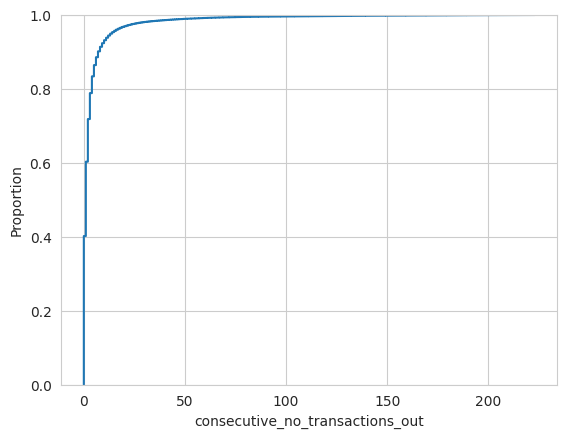

In [22]:
sns.ecdfplot(data=cluster_station[cluster_station["status"] == 1], x="consecutive_no_transactions_out")

In [23]:
PROFILE_STATION_RULE[profile_station_activity]

36

In [24]:
cluster_station.shape

(65215, 26)

In [25]:
cluster_station.head(2)

station_id                date  available_stands  available_bikes  \
6616164         106 2018-12-01 00:10:00                18               20   
6616165         106 2018-12-01 00:20:00                15               23   

         status  transactions_in  transactions_out  transactions_all  \
6616164       1                0                 0                 0   
6616165       1                3                 0                 3   

         consecutive_no_transactions_out  quarter  weekday  hours  \
6616164                                1        4        6      0   
6616165                                2        4        6      0   

          Sin_quarter  Cos_quarter  Sin_weekday  Cos_weekday  Sin_hours  \
6616164 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616165 -2.449294e-16          1.0    -0.781831      0.62349        0.0   

         Cos_hours     pca_1     pca_2     pca_3     pca_4     pca_5  \
6616164        1.0  1.046731  0.003525 -0.066745  1.084290 -1.043315   
6616165        1.0  1.762295 -0.016660 -0.032448  1.085313 -1.024725   

            pca_6     pca_7  cluster  
6616164 -0.729108  0.322639        1  
6616165 -0.794536  1.016727        1

In [26]:
cluster_station.consecutive_no_transactions_out.describe(percentiles=[0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.98])

count    65215.000000
mean         3.655493
std         12.054918
min          0.000000
50%          1.000000
75%          3.000000
80%          4.000000
85%          5.000000
90%          7.000000
95%         14.000000
98%         29.000000
99%         52.000000
max        223.000000
Name: consecutive_no_transactions_out, dtype: float64

In [27]:
cluster_station.head()

station_id                date  available_stands  available_bikes  \
6616164         106 2018-12-01 00:10:00                18               20   
6616165         106 2018-12-01 00:20:00                15               23   
6616166         106 2018-12-01 00:30:00                14               24   
6616167         106 2018-12-01 00:40:00                14               24   
6616168         106 2018-12-01 00:50:00                13               25   

         status  transactions_in  transactions_out  transactions_all  \
6616164       1                0                 0                 0   
6616165       1                3                 0                 3   
6616166       1                1                 0                 1   
6616167       1                2                 2                 4   
6616168       1                1                 0                 1   

         consecutive_no_transactions_out  quarter  weekday  hours  \
6616164                                1        4        6      0   
6616165                                2        4        6      0   
6616166                                3        4        6      0   
6616167                                0        4        6      0   
6616168                                1        4        6      0   

          Sin_quarter  Cos_quarter  Sin_weekday  Cos_weekday  Sin_hours  \
6616164 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616165 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616166 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616167 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616168 -2.449294e-16          1.0    -0.781831      0.62349        0.0   

         Cos_hours     pca_1     pca_2     pca_3     pca_4     pca_5  \
6616164        1.0  1.046731  0.003525 -0.066745  1.084290 -1.043315   
6616165        1.0  1.762295 -0.016660 -0.032448  1.085313 -1.024725   
6616166        1.0  2.477858 -0.036844  0.001849  1.086337 -1.006134   
6616167        1.0  0.331168  0.023709 -0.101042  1.083267 -1.061905   
6616168        1.0  1.046731  0.003525 -0.066745  1.084290 -1.043315   

            pca_6     pca_7  cluster  
6616164 -0.729108  0.322639        1  
6616165 -0.794536  1.016727        1  
6616166 -0.859964  1.710815        1  
6616167 -0.663680 -0.371449        1  
6616168 -0.729108  0.322639        1

In [ ]:
# Graph
# Type date for better display in graph
cluster_station["date_str"] = cluster_station["date"].dt.strftime(date_format="%Y-%m-%d %H:%M")

fig = px.scatter(
    cluster_station,
    x="pca_1",
    y="pca_2",
    color="cluster",  #'cluster_info'
    hover_data=[
        "date_str",
        "available_bikes",
        "weekday",
        "hours",
        "consecutive_no_transactions_out",
        #'precipitation'
    ],
)
fig.show()

# Drop non usefull columns
cluster_station = cluster_station.drop("date_str", axis=1)

In [32]:
cluster_station.head()

station_id                date  available_stands  available_bikes  \
6616164         106 2018-12-01 00:10:00                18               20   
6616165         106 2018-12-01 00:20:00                15               23   
6616166         106 2018-12-01 00:30:00                14               24   
6616167         106 2018-12-01 00:40:00                14               24   
6616168         106 2018-12-01 00:50:00                13               25   

         status  transactions_in  transactions_out  transactions_all  \
6616164       1                0                 0                 0   
6616165       1                3                 0                 3   
6616166       1                1                 0                 1   
6616167       1                2                 2                 4   
6616168       1                1                 0                 1   

         consecutive_no_transactions_out  quarter  weekday  hours  \
6616164                                1        4        6      0   
6616165                                2        4        6      0   
6616166                                3        4        6      0   
6616167                                0        4        6      0   
6616168                                1        4        6      0   

          Sin_quarter  Cos_quarter  Sin_weekday  Cos_weekday  Sin_hours  \
6616164 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616165 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616166 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616167 -2.449294e-16          1.0    -0.781831      0.62349        0.0   
6616168 -2.449294e-16          1.0    -0.781831      0.62349        0.0   

         Cos_hours     pca_1     pca_2     pca_3     pca_4     pca_5  \
6616164        1.0  1.046731  0.003525 -0.066745  1.084290 -1.043315   
6616165        1.0  1.762295 -0.016660 -0.032448  1.085313 -1.024725   
6616166        1.0  2.477858 -0.036844  0.001849  1.086337 -1.006134   
6616167        1.0  0.331168  0.023709 -0.101042  1.083267 -1.061905   
6616168        1.0  1.046731  0.003525 -0.066745  1.084290 -1.043315   

            pca_6     pca_7  cluster  
6616164 -0.729108  0.322639        1  
6616165 -0.794536  1.016727        1  
6616166 -0.859964  1.710815        1  
6616167 -0.663680 -0.371449        1  
6616168 -0.729108  0.322639        1

In [ ]:
cluster_station["date_str"] = cluster_station["date"].dt.strftime(date_format="%Y-%m-%d %H:%M")

fig = px.scatter_3d(
    cluster_station,
    x="pca_4",
    y="pca_5",
    z="pca_1",
    color="consecutive_no_transactions_out",
    hover_data=[
        "date_str",
        "available_stands",
        "available_stands",
        "weekday",
        "hours",
        "consecutive_no_transactions_out",
    ],
    opacity=0.5,
    size_max=1,
    labels={"cluster": "Anomaly"},
)  # color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()

In [35]:
cluster_station.cluster.value_counts(normalize=True)

cluster
 1    0.986261
-1    0.013739
Name: proportion, dtype: float64

In [36]:
cluster_station[cluster_station["cluster"] == -1]

station_id                date  available_stands  available_bikes  \
6632621         106 2019-06-19 06:00:00                 8               19   
6632622         106 2019-06-19 06:10:00                 8               19   
6632623         106 2019-06-19 06:20:00                 8               19   
6632624         106 2019-06-19 06:30:00                 8               19   
6632625         106 2019-06-19 06:40:00                 8               19   
...             ...                 ...               ...              ...   
6681336         106 2020-08-28 04:50:00                 9               31   
6681337         106 2020-08-28 05:00:00                 9               31   
6681338         106 2020-08-28 05:10:00                 9               31   
6681339         106 2020-08-28 05:20:00                 9               31   
6681340         106 2020-08-28 05:30:00                 9               31   

         status  transactions_in  transactions_out  transactions_all  \
6632621       1                0                 0                 0   
6632622       1                0                 0                 0   
6632623       1                0                 0                 0   
6632624       1                0                 0                 0   
6632625       1                0                 0                 0   
...         ...              ...               ...               ...   
6681336       1                0                 0                 0   
6681337       1                0                 0                 0   
6681338       1                0                 0                 0   
6681339       1                0                 0                 0   
6681340       1                0                 0                 0   

         consecutive_no_transactions_out  quarter  weekday  hours  \
6632621                               43        2        3      6   
6632622                               44        2        3      6   
6632623                               45        2        3      6   
6632624                               46        2        3      6   
6632625                               47        2        3      6   
...                                  ...      ...      ...    ...   
6681336                               46        3        5      4   
6681337                               47        3        5      5   
6681338                               48        3        5      5   
6681339                               49        3        5      5   
6681340                               50        3        5      5   

          Sin_quarter   Cos_quarter  Sin_weekday  Cos_weekday  Sin_hours  \
6632621  1.224647e-16 -1.000000e+00     0.433884    -0.900969   1.000000   
6632622  1.224647e-16 -1.000000e+00     0.433884    -0.900969   1.000000   
6632623  1.224647e-16 -1.000000e+00     0.433884    -0.900969   1.000000   
6632624  1.224647e-16 -1.000000e+00     0.433884    -0.900969   1.000000   
6632625  1.224647e-16 -1.000000e+00     0.433884    -0.900969   1.000000   
...               ...           ...          ...          ...        ...   
6681336 -1.000000e+00 -1.836970e-16    -0.974928    -0.222521   0.866025   
6681337 -1.000000e+00 -1.836970e-16    -0.974928    -0.222521   0.965926   
6681338 -1.000000e+00 -1.836970e-16    -0.974928    -0.222521   0.965926   
6681339 -1.000000e+00 -1.836970e-16    -0.974928    -0.222521   0.965926   
6681340 -1.000000e+00 -1.836970e-16    -0.974928    -0.222521   0.965926   

            Cos_hours      pca_1     pca_2     pca_3     pca_4     pca_5  \
6632621  6.123234e-17  30.903147 -0.944559  1.070896 -0.112419  1.590132   
6632622  6.123234e-17  31.618710 -0.964743  1.105193 -0.111396  1.608722   
6632623  6.123234e-17  32.334273 -0.984928  1.139490 -0.110373  1.627313   
6632624  6.123234e-17  33.049837 -1.005112  1.173787 -0.109349  1.645903   
6632625  6.123234e-17  33.765400 -1.025296  1.208085 -0.108326  1.664494   
...      

In [37]:
cluster_station[cluster_station["cluster"] == -1]["consecutive_no_transactions_out"].describe()

count    896.000000
mean      85.227679
std       46.891025
min       30.000000
25%       50.000000
50%       67.000000
75%      111.000000
max      223.000000
Name: consecutive_no_transactions_out, dtype: float64

In [38]:
cluster_station["anomaly"] = cluster_station["cluster"]

In [39]:
cluster_station[cluster_station["status"] == 0]["date"].nunique() / 6 / 24

1.9444444444444444

<Axes: xlabel='cluster', ylabel='consecutive_no_transactions_out'>

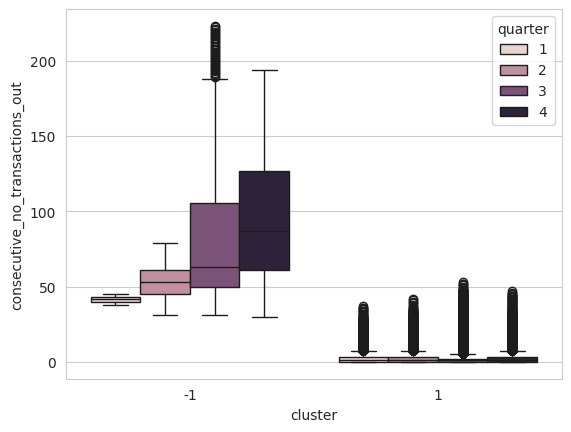

In [40]:
sns.boxplot(data=cluster_station, x="cluster", y="consecutive_no_transactions_out", hue="quarter")

In [41]:
cluster_station[cluster_station["cluster"] == -1].groupby("quarter")["cluster"].count()

quarter
1      8
2     98
3    471
4    319
Name: cluster, dtype: int64

In [42]:
# Lecture de profile des stations pour connaitre ceux que l'on clusterise
station_profile = read_station_profile(path_directory=ROOT_DATA_REF).to_pandas()

stations_id_to_fit = station_profile[station_profile["mean"] >= THRESHOLD_PROFILE_STATION]["station_id"].unique()

# Filter station we don't want to use
stations_id_to_fit = [station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

In [43]:
[station for station in stations_id_to_fit if station not in NON_USE_STATION_ID]

[np.uint16(124),
 np.uint16(15),
 np.uint16(60),
 np.uint16(18),
 np.uint16(10),
 np.uint16(68),
 np.uint16(130),
 np.uint16(2),
 np.uint16(105),
 np.uint16(120),
 np.uint16(11),
 np.uint16(110),
 np.uint16(9),
 np.uint16(23),
 np.uint16(3),
 np.uint16(16),
 np.uint16(20),
 np.uint16(136),
 np.uint16(42),
 np.uint16(21),
 np.uint16(131),
 np.uint16(59),
 np.uint16(45),
 np.uint16(172),
 np.uint16(6),
 np.uint16(36),
 np.uint16(24),
 np.uint16(108),
 np.uint16(19),
 np.uint16(125),
 np.uint16(135),
 np.uint16(37),
 np.uint16(139),
 np.uint16(99),
 np.uint16(28),
 np.uint16(57),
 np.uint16(7),
 np.uint16(98),
 np.uint16(8),
 np.uint16(40),
 np.uint16(41),
 np.uint16(58),
 np.uint16(55),
 np.uint16(109),
 np.uint16(4),
 np.uint16(1),
 np.uint16(100),
 np.uint16(174),
 np.uint16(134),
 np.uint16(56),
 np.uint16(101),
 np.uint16(104),
 np.uint16(43),
 np.uint16(54),
 np.uint16(44),
 np.uint16(102),
 np.uint16(133),
 np.uint16(103),
 np.uint16(5),
 np.uint16(127),
 np.uint16(65),
 np.uint16(

In [44]:
from vcub_keeper.reader.reader_utils import filter_periode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
ts_activity.date.max()

Timestamp('2020-08-28 11:50:00')

In [46]:
station_id = 62

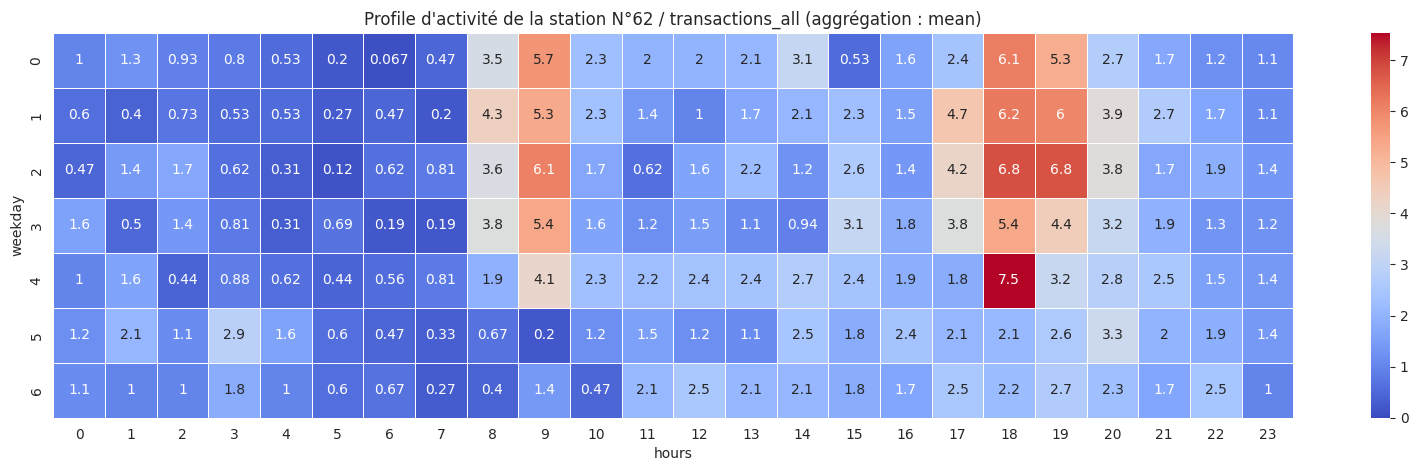

In [47]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_all",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

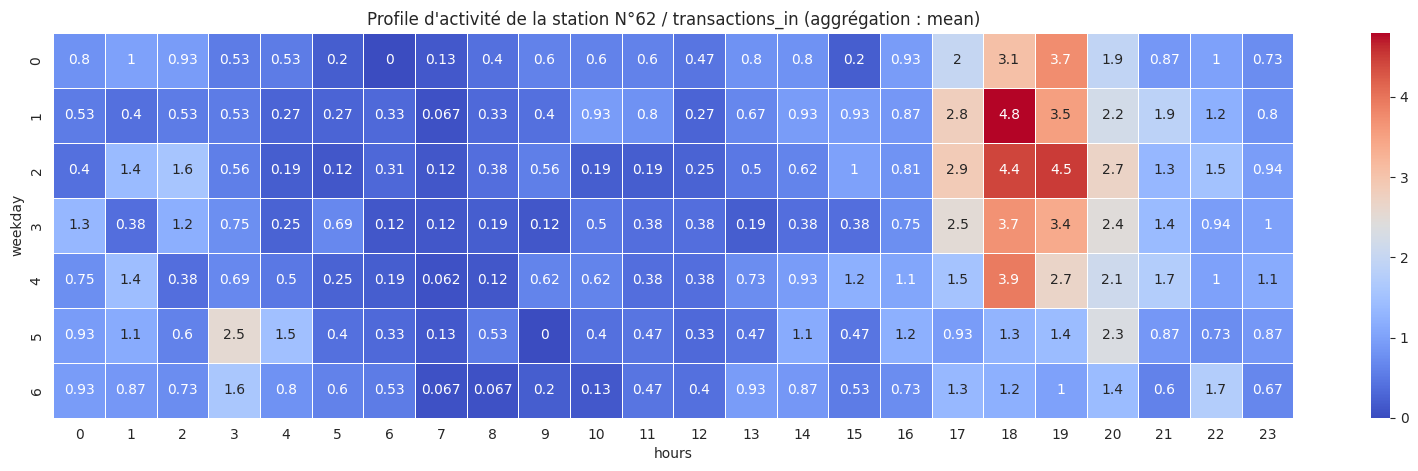

In [48]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_in",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

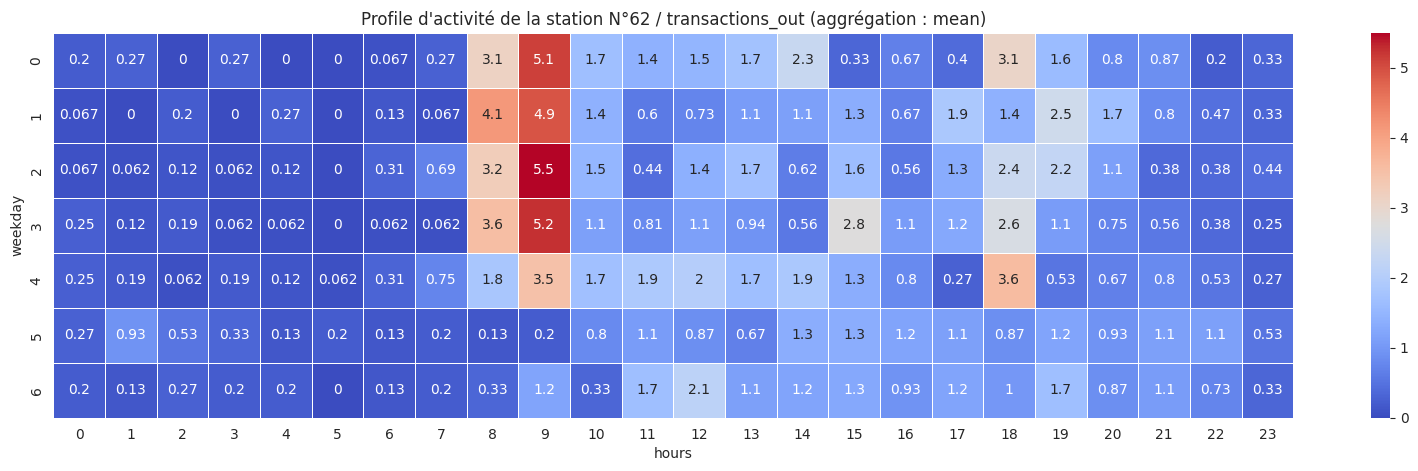

In [49]:
plot_profile_station(
    ts_activity[ts_activity["date"] >= "2020-03-17"],
    station_id=station_id,
    feature_to_plot="transactions_out",
    aggfunc="mean",
    filter_data=True,
    vmin=0,
)

#### On compare par rapport au données post-covid

In [106]:
from vcub_keeper.production.data import get_data_from_api_by_station, transform_json_station_data_to_df

station_json = get_data_from_api_by_station(station_id=station_id, start_date="2021/09/04", stop_date="2021/11/18")

station_df = transform_json_station_data_to_df(station_json)

station_df = get_consecutive_no_transactions_out(station_df).collect().to_pandas()

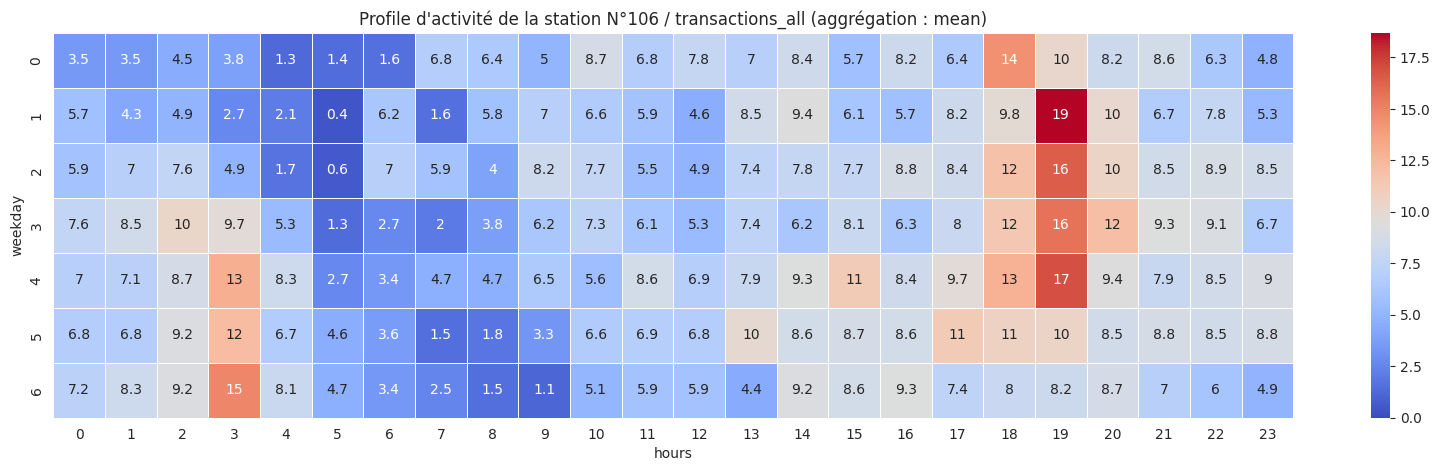

In [107]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_all", aggfunc="mean", filter_data=True, vmin=0
)

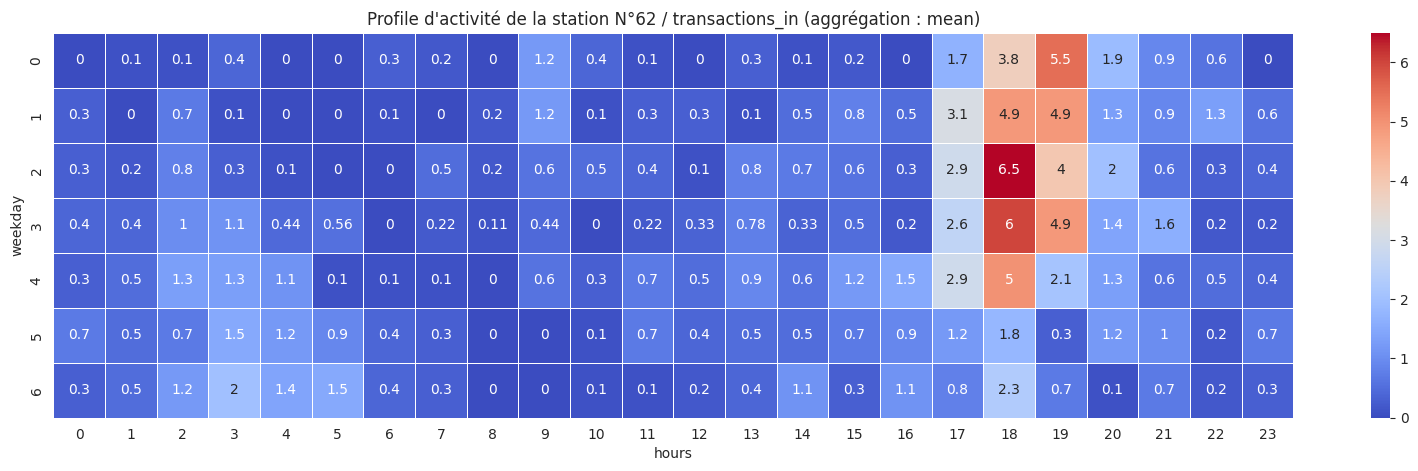

In [97]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_in", aggfunc="mean", filter_data=True, vmin=0
)

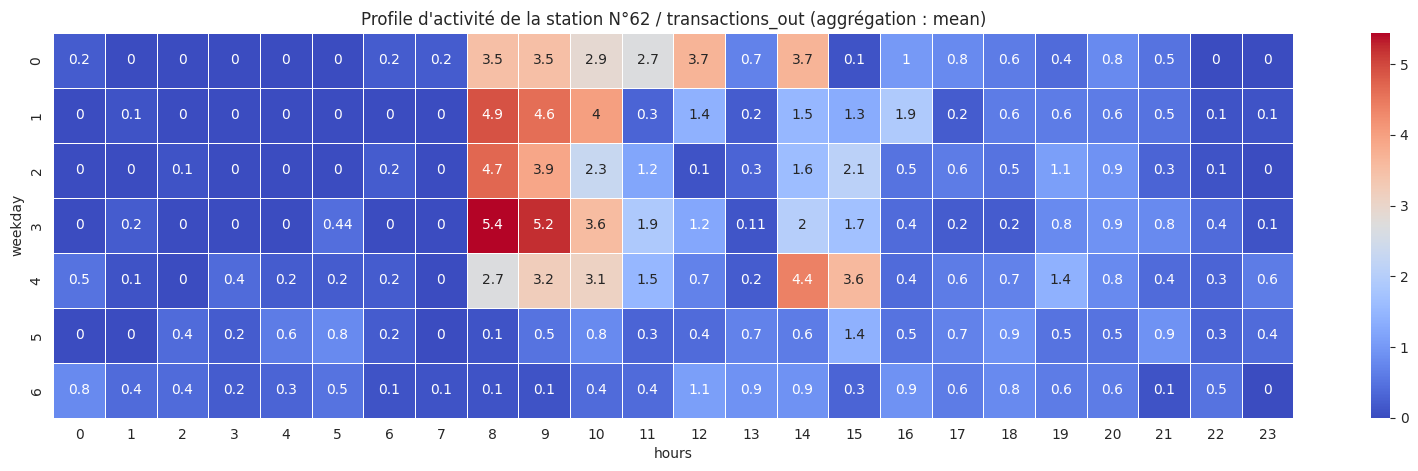

In [98]:
plot_profile_station(
    station_df, station_id=station_id, feature_to_plot="transactions_out", aggfunc="mean", filter_data=True, vmin=0
)

## Industrialisation

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Lecture du fichier activité
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Some features
# ts_activity = get_transactions_in(ts_activity)
# ts_activity = get_transactions_out(ts_activity)
# ts_activity = get_transactions_all(ts_activity)
ts_activity = get_consecutive_no_transactions_out(ts_activity)

In [54]:
station_id = 106

In [55]:
clf = train_cluster_station(ts_activity, station_id=station_id)
#  0.004647817613759431

Profile de la station N°106 : very high
Contamination de la station : 0.013795018979724127


In [56]:
# Faire une prédiction d'une station
station_pred = predict_anomalies_station(data=ts_activity, clf=clf, station_id=station_id)

In [57]:
station_pred["consecutive_no_transactions_out"].describe()

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 72853.0   │
│ null_count ┆ 0.0       │
│ mean       ┆ 5.114669  │
│ std        ┆ 13.700496 │
│ min        ┆ 0.0       │
│ 25%        ┆ 0.0       │
│ 50%        ┆ 1.0       │
│ 75%        ┆ 4.0       │
│ max        ┆ 223.0     │
└────────────┴───────────┘

In [69]:
station_pred["anomaly"].value_counts()
# station_pred.select("anomaly").to_series().value_counts()
# station_pred.group_by("anomaly").len()

shape: (2, 2)
┌─────────┬───────┐
│ anomaly ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 1       ┆ 70669 │
│ -1      ┆ 2184  │
└─────────┴───────┘

In [70]:
station_pred.select("anomaly").to_series().value_counts(normalize=True)

shape: (2, 2)
┌─────────┬────────────┐
│ anomaly ┆ proportion │
│ ---     ┆ ---        │
│ i64     ┆ f64        │
╞═════════╪════════════╡
│ -1      ┆ 0.029978   │
│ 1       ┆ 0.970022   │
└─────────┴────────────┘

In [71]:
station_pred.filter(pl.col("anomaly") == -1).group_by("quarter").len()

shape: (4, 2)
┌─────────┬──────┐
│ quarter ┆ len  │
│ ---     ┆ ---  │
│ i8      ┆ u32  │
╞═════════╪══════╡
│ 3       ┆ 471  │
│ 2       ┆ 1051 │
│ 1       ┆ 343  │
│ 4       ┆ 319  │
└─────────┴──────┘

In [72]:
# Score anomaly
# station_pred["anomaly_score"] = (
#     logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER])) * 100
# )

predictions = clf.predict(station_pred.select(FEATURES_TO_USE_CLUSTER))
station_pred = station_pred.with_columns(pl.Series(name="anomaly", values=predictions))

In [73]:
# station_pred[(station_pred["anomaly"] == -1) & (station_pred["consecutive_no_transactions_out"] < 36)].sort_values(
#     "consecutive_no_transactions_out"
# )

station_pred.filter((pl.col("anomaly") == -1) & (pl.col("consecutive_no_transactions_out") < 36)).sort(
    "consecutive_no_transactions_out"
)

shape: (167, 19)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ station_id ┆ date      ┆ available ┆ available ┆ … ┆ Cos_weekd ┆ Sin_hours ┆ Cos_hours ┆ anomaly │
│ ---        ┆ ---       ┆ _stands   ┆ _bikes    ┆   ┆ ay        ┆ ---       ┆ ---       ┆ ---     │
│ u8         ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆ i64     │
│            ┆ ns]       ┆ i8        ┆ i8        ┆   ┆ f64       ┆           ┆           ┆         │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ 106        ┆ 2020-04-2 ┆ 17        ┆ 23        ┆ … ┆ -0.222521 ┆ 0.707107  ┆ 0.707107  ┆ -1      │
│            ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 03:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 11        ┆ 29        ┆ … ┆ -0.222521 ┆ 0.707107  ┆ 0.707107  ┆ -1      │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 03:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 11        ┆ 29        ┆ … ┆ -0.222521 ┆ 0.707107  ┆ 0.707107  ┆ -1      │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 03:40:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-04-2 ┆ 17        ┆ 23        ┆ … ┆ -0.222521 ┆ 0.866025  ┆ 0.5       ┆ -1      │
│            ┆ 4         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 04:10:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 11        ┆ 29        ┆ … ┆ -0.222521 ┆ 0.707107  ┆ 0.707107  ┆ -1      │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 03:50:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ …          ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …       │
│ 106        ┆ 2020-05-0 ┆ 9         ┆ 31        ┆ … ┆ 1.0       ┆ 0.707107  ┆ 0.707107  ┆ -1      │
│            ┆ 3         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 03:20:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 8         ┆ 32        ┆ … ┆ -0.222521 ┆ 0.258819  ┆ 0.965926  ┆ -1      │
│            ┆ 5         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 01:40:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 11        ┆ 29        ┆ … ┆ -0.222521 ┆ 0.965926  ┆ 0.258819  ┆ -1      │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 05:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-0 ┆ 12        ┆ 28        ┆ … ┆ 0.62349   ┆ 0.965926  ┆ 0.258819  ┆ -1      │
│            ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 05:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│ 106        ┆ 2020-05-1 ┆ 9         ┆ 31        ┆ … ┆ 1.0       ┆ -0.5      ┆ 0.866025  ┆ -1      │
│            ┆ 0         ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
│            ┆ 22:30:00  ┆           ┆           ┆   ┆           ┆           ┆           ┆         │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴─────────┘

In [108]:
# On essaye de produire des probabilité à partir du score d'anomaly d'Iosaltion Forest
# OLD
# CF https://stackoverflow.com/a/69577241

# from scipy.special import erf


# def convert_probabilities(data, model):
#     decision_scores = -model.decision_function(data)
#     probs = np.zeros([data.shape[0], 2])  # int(model.classes)])
#     pre_erf_score = (decision_scores - np.mean(decision_scores)) / (np.std(decision_scores) * np.sqrt(2))
#     erf_score = erf(pre_erf_score)
#     probs[:, 1] = erf_score.clip(0, 1).ravel()
#     probs[:, 0] = 1 - probs[:, 1]
#     return probs[:, 1]


# station_pred['anoamlie_score_scale_2'] = convert_probabilities(station_pred[FEATURES_TO_USE_CLUSTER],
#                                                               clf) * 100

In [86]:
station_pred = station_pred.with_columns(
    pl.Series(
        name="anomaly_score",
        values=logistic_predict_proba_from_model(clf.decision_function(station_pred.select(FEATURES_TO_USE_CLUSTER)))
        * 100,
    )
)

In [91]:
station_pred.filter(pl.col("anomaly") == -1).group_by("quarter").agg(
    pl.col("anomaly_score")
).describe()  # .transpose(include_header=False)

shape: (9, 3)
┌────────────┬──────────┬───────────────┐
│ statistic  ┆ quarter  ┆ anomaly_score │
│ ---        ┆ ---      ┆ ---           │
│ str        ┆ f64      ┆ f64           │
╞════════════╪══════════╪═══════════════╡
│ count      ┆ 4.0      ┆ 4.0           │
│ null_count ┆ 0.0      ┆ 0.0           │
│ mean       ┆ 2.5      ┆ null          │
│ std        ┆ 1.290994 ┆ null          │
│ min        ┆ 1.0      ┆ null          │
│ 25%        ┆ 2.0      ┆ null          │
│ 50%        ┆ 3.0      ┆ null          │
│ 75%        ┆ 3.0      ┆ null          │
│ max        ┆ 4.0      ┆ null          │
└────────────┴──────────┴───────────────┘

In [139]:
# Export model
# export_model(clf, station_id=station_id, path_directory=ROOT_MODEL)

In [140]:
# Chargement model
# clf = load_model(station_id=station_id)

In [92]:
# Analyser données graphique à partir d'une date
# station_pred[station_pred.date >= "2019-04-16 11:10:00"].head(80)
station_pred

shape: (72_853, 20)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ station_id ┆ date      ┆ available ┆ available ┆ … ┆ Sin_hours ┆ Cos_hours ┆ anomaly ┆ anomaly_s │
│ ---        ┆ ---       ┆ _stands   ┆ _bikes    ┆   ┆ ---       ┆ ---       ┆ ---     ┆ core      │
│ u8         ┆ datetime[ ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ i64     ┆ ---       │
│            ┆ ns]       ┆ i8        ┆ i8        ┆   ┆           ┆           ┆         ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ 106        ┆ 2018-12-0 ┆ 18        ┆ 20        ┆ … ┆ 0.0       ┆ 1.0       ┆ 1       ┆ 17.166711 │
│            ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 00:10:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2018-12-0 ┆ 15        ┆ 23        ┆ … ┆ 0.0       ┆ 1.0       ┆ 1       ┆ 16.826342 │
│            ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 00:20:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2018-12-0 ┆ 14        ┆ 24        ┆ … ┆ 0.0       ┆ 1.0       ┆ 1       ┆ 16.01186  │
│            ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 00:30:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2018-12-0 ┆ 14        ┆ 24        ┆ … ┆ 0.0       ┆ 1.0       ┆ 1       ┆ 17.457077 │
│            ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 00:40:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2018-12-0 ┆ 13        ┆ 25        ┆ … ┆ 0.0       ┆ 1.0       ┆ 1       ┆ 17.166711 │
│            ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 00:50:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ …          ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …       ┆ …         │
│ 106        ┆ 2020-08-2 ┆ 20        ┆ 20        ┆ … ┆ 0.258819  ┆ -0.965926 ┆ 1       ┆ 17.734482 │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 11:10:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2020-08-2 ┆ 20        ┆ 20        ┆ … ┆ 0.258819  ┆ -0.965926 ┆ 1       ┆ 17.89857  │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 11:20:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2020-08-2 ┆ 20        ┆ 20        ┆ … ┆ 0.258819  ┆ -0.965926 ┆ 1       ┆ 17.98444  │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 11:30:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2020-08-2 ┆ 20        ┆ 20        ┆ … ┆ 0.258819  ┆ -0.965926 ┆ 1       ┆ 18.578386 │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 11:40:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│ 106        ┆ 2020-08-2 ┆ 20        ┆ 20        ┆ … ┆ 0.258819  ┆ -0.965926 ┆ 1       ┆ 19.581059 │
│            ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
│            ┆ 11:50:00  ┆           ┆           ┆   ┆           ┆           ┆         ┆           │
└────────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴─────────┴───────────┘

In [93]:
# Pour le language des dates sur le graphique
# NE MARCHE PAS
# import locale

# locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# ts_activity.head().date.dt.strftime('%a %Y-%m-%d %H:%M') # MARCHE SUR PANDAS

In [96]:
fig = px.scatter(
    x=clf.decision_function(station_pred.select(FEATURES_TO_USE_CLUSTER)),
    y=logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]), k=20),
)
fig.show()

<Axes: ylabel='Proportion'>

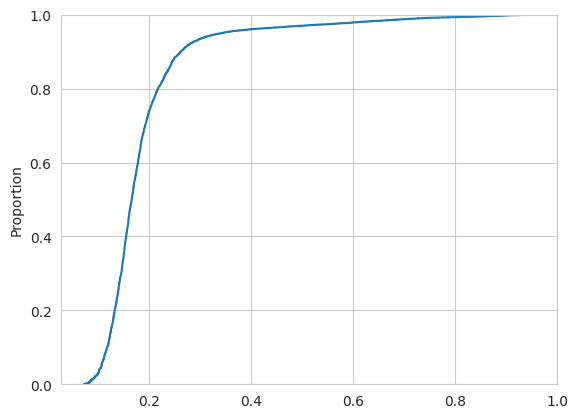

In [97]:
# fig = px.ecdf(decision_function)
sns.ecdfplot(logistic_predict_proba_from_model(clf.decision_function(station_pred[FEATURES_TO_USE_CLUSTER]), k=20))

In [98]:
logistic_predict_proba_from_model(-0.182787, k=20)

np.float64(0.9748086373851281)

In [99]:
logistic_predict_proba_from_model(0.15, k=20)

np.float64(0.04742587317756678)

### Analyse du score d'anomalie pour un trimestre différent

In [100]:
test_saison = [
    {"station_id": station_id, "date": pd.Timestamp("2019-01-05 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-04-06 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-07-06 09:40:00"), "consecutive_no_transactions_out": 38},
    {"station_id": station_id, "date": pd.Timestamp("2019-10-05 09:40:00"), "consecutive_no_transactions_out": 38},
]

test_saison_df = pl.DataFrame(test_saison)
test_saison_df

shape: (4, 3)
┌────────────┬─────────────────────┬─────────────────────────────────┐
│ station_id ┆ date                ┆ consecutive_no_transactions_ou… │
│ ---        ┆ ---                 ┆ ---                             │
│ i64        ┆ datetime[μs]        ┆ i64                             │
╞════════════╪═════════════════════╪═════════════════════════════════╡
│ 106        ┆ 2019-01-05 09:40:00 ┆ 38                              │
│ 106        ┆ 2019-04-06 09:40:00 ┆ 38                              │
│ 106        ┆ 2019-07-06 09:40:00 ┆ 38                              │
│ 106        ┆ 2019-10-05 09:40:00 ┆ 38                              │
└────────────┴─────────────────────┴─────────────────────────────────┘

In [101]:
test_saison_df_build = process_data_cluster(test_saison_df)
test_saison_df_build

shape: (4, 12)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ station_id ┆ date      ┆ consecuti ┆ quarter ┆ … ┆ Sin_weekd ┆ Cos_weekd ┆ Sin_hours ┆ Cos_hours │
│ ---        ┆ ---       ┆ ve_no_tra ┆ ---     ┆   ┆ ay        ┆ ay        ┆ ---       ┆ ---       │
│ i64        ┆ datetime[ ┆ nsactions ┆ i8      ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│            ┆ μs]       ┆ _ou…      ┆         ┆   ┆ f64       ┆ f64       ┆           ┆           │
│            ┆           ┆ ---       ┆         ┆   ┆           ┆           ┆           ┆           │
│            ┆           ┆ i64       ┆         ┆   ┆           ┆           ┆           ┆           │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 106        ┆ 2019-01-0 ┆ 38        ┆ 1       ┆ … ┆ -0.781831 ┆ 0.62349   ┆ 0.707107  ┆ -0.707107 │
│            ┆ 5         ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│            ┆ 09:40:00  ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│ 106        ┆ 2019-04-0 ┆ 38        ┆ 2       ┆ … ┆ -0.781831 ┆ 0.62349   ┆ 0.707107  ┆ -0.707107 │
│            ┆ 6         ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│            ┆ 09:40:00  ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│ 106        ┆ 2019-07-0 ┆ 38        ┆ 3       ┆ … ┆ -0.781831 ┆ 0.62349   ┆ 0.707107  ┆ -0.707107 │
│            ┆ 6         ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│            ┆ 09:40:00  ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│ 106        ┆ 2019-10-0 ┆ 38        ┆ 4       ┆ … ┆ -0.781831 ┆ 0.62349   ┆ 0.707107  ┆ -0.707107 │
│            ┆ 5         ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
│            ┆ 09:40:00  ┆           ┆         ┆   ┆           ┆           ┆           ┆           │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [102]:
test_saison_df_build = test_saison_df_build.with_columns(
    pl.Series(
        name="anomaly_score",
        values=logistic_predict_proba_from_model(
            clf.decision_function(test_saison_df_build.select(FEATURES_TO_USE_CLUSTER))
        )
        * 100,
    )
)

In [103]:
test_saison_df_build.select(
    "station_id", "date", "quarter", "weekday", "consecutive_no_transactions_out", "anomaly_score"
)

shape: (4, 6)
┌────────────┬─────────────────────┬─────────┬─────────┬───────────────────────────┬───────────────┐
│ station_id ┆ date                ┆ quarter ┆ weekday ┆ consecutive_no_transactio ┆ anomaly_score │
│ ---        ┆ ---                 ┆ ---     ┆ ---     ┆ ns_ou…                    ┆ ---           │
│ i64        ┆ datetime[μs]        ┆ i8      ┆ i8      ┆ ---                       ┆ f64           │
│            ┆                     ┆         ┆         ┆ i64                       ┆               │
╞════════════╪═════════════════════╪═════════╪═════════╪═══════════════════════════╪═══════════════╡
│ 106        ┆ 2019-01-05 09:40:00 ┆ 1       ┆ 6       ┆ 38                        ┆ 50.600228     │
│ 106        ┆ 2019-04-06 09:40:00 ┆ 2       ┆ 6       ┆ 38                        ┆ 56.343653     │
│ 106        ┆ 2019-07-06 09:40:00 ┆ 3       ┆ 6       ┆ 38                        ┆ 39.431555     │
│ 106        ┆ 2019-10-05 09:40:00 ┆ 4       ┆ 6       ┆ 38                        ┆ 41.378283     │
└────────────┴─────────────────────┴─────────┴─────────┴───────────────────────────┴───────────────┘

In [104]:
filter_periode(station_pred, non_use_station_id=NON_USE_STATION_ID).group_by("quarter").len()

shape: (4, 2)
┌─────────┬───────┐
│ quarter ┆ len   │
│ ---     ┆ ---   │
│ i8      ┆ u32   │
╞═════════╪═══════╡
│ 1       ┆ 17517 │
│ 4       ┆ 13426 │
│ 3       ┆ 20084 │
│ 2       ┆ 14188 │
└─────────┴───────┘

### Réalistion des tests

Cf fichier tests.test_ml.py

In [158]:
from vcub_keeper.ml.cluster import logistic_predict_proba_from_model, predict_anomalies_station, train_cluster_station
from vcub_keeper.production.data import get_data_from_api_by_station, transform_json_station_data_to_df
from vcub_keeper.transform.features_factory import get_consecutive_no_transactions_out, process_data_cluster

# test_data name in test script
test_data = [
    (
        [{"station_id": 106, "date": pd.Timestamp("2018-12-01 00:10:00"), "consecutive_no_transactions_out": 0}],
        1,
    ),  # Should be OK
    (
        [{"station_id": 106, "date": pd.Timestamp("2020-08-25 03:50:00"), "consecutive_no_transactions_out": 46}],
        -1,
    ),  # Should be KO (anomaly)
]

station_id = 106
start_date = "2018-12-01"
stop_date = "2020-08-28"
profile_station_activity = "very high"  # https://github.com/armgilles/vcub_keeper/issues/56#issuecomment-1007612158

station_json = get_data_from_api_by_station(station_id=station_id, start_date=start_date, stop_date=stop_date)

station_df = transform_json_station_data_to_df(station_json)

# Create feature basé sur l'absence consécutive de prise de vcub sur la station
station_df = get_consecutive_no_transactions_out(station_df)

clf = train_cluster_station(
    station_df.to_pandas(), station_id=station_id, profile_station_activity=profile_station_activity
)

# Prediction
station_df_pred = predict_anomalies_station(data=station_df.to_pandas(), clf=clf, station_id=station_id)

# Check prediction sanity
# Check features creation is the same as FEATURES_TO_USE_CLUSTER (from config.py)
assert (station_df_pred[FEATURES_TO_USE_CLUSTER].columns == FEATURES_TO_USE_CLUSTER).any()  # noqa: S101

Using specifique profile station activity : very high
Profile de la station N°106 : very high
Contamination de la station : 0.012818927815296255


In [159]:
station_df_pred[
    station_df_pred["date"].isin(
        [
            "2018-12-01 00:10:00",  # Date in test_data
            "2020-08-25 03:50:00",
        ]
    )
]

/tmp/ipykernel_2324896/3197435770.py:1: FutureWarning:

The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



date  station_id  available_stands  available_bikes  \
0     2018-12-01 00:10:00         106              18.0             20.0   
91174 2020-08-25 03:50:00         106              26.0             14.0   

       status  transactions_in  transactions_out  transactions_all  \
0         1.0                0                 0                 0   
91174     1.0                0                 0                 0   

       consecutive_no_transactions_out  quarter  weekday  hours   Sin_quarter  \
0                                    1        4        6      0 -2.449294e-16   
91174                               46        3        2      3 -1.000000e+00   

        Cos_quarter  Sin_weekday  Cos_weekday  Sin_hours  Cos_hours  anomaly  
0      1.000000e+00    -0.781831     0.623490   0.000000   1.000000        1  
91174 -1.836970e-16     0.974928    -0.222521   0.707107   0.707107       -1

In [160]:
station_df_pred["anomaly_score"] = (
    logistic_predict_proba_from_model(clf.decision_function(station_df_pred[FEATURES_TO_USE_CLUSTER])) * 100
)

In [161]:
# test_data#['date']
for i in test_data:
    print(i)

([{'station_id': 106, 'date': Timestamp('2018-12-01 00:10:00'), 'consecutive_no_transactions_out': 0}], 1)
([{'station_id': 106, 'date': Timestamp('2020-08-25 03:50:00'), 'consecutive_no_transactions_out': 46}], -1)


In [162]:
i[0][0]["date"]

Timestamp('2020-08-25 03:50:00')